In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, least_squares

try:
    df = pd.read_csv("xy_data.csv")
    x_data = df['x'].values
    y_data = df['y'].values
    N = len(df)
    # Given t varies between [6,60]
    t_target = np.linspace(6, 60, N)
    print(f"Data loaded: {N} points. Target t-vector created.")
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

Data loaded: 1500 points. Target t-vector created.


In [14]:
#--- 2. Define Bounds ---
#We need to initialize the minimum and maximum bounds for the theta parameter
theta_min_rad = np.deg2rad(0.0) + 1e-6 #epsilon to avoid 0
theta_max_rad = np.deg2rad(50.0)

In [15]:
# Bounds for the differential_evolution
bounds_de = [
    (theta_min_rad, theta_max_rad),  # theta (radians)
    (-0.05, 0.05),                  # M
    (0.0, 100.0)                    # X
]

# Bounds for least_squares (different format)
bounds_ls = (
    [theta_min_rad, -0.05, 0.0],
    [theta_max_rad, 0.05, 100.0]
)

In [16]:
print(df.head())

            x          y
0   88.364456  57.784378
1   74.283936  54.406780
2   60.256474  46.311462
3   82.134370  57.717567
4  101.036390  67.849340


In [17]:
#Lets transform (x,y) => (x',y')
# (x,y)=>(x_bar,y_bar)=>Rot(-theta)([x_bar,y_bar])=(x',y'); where x_bar=x-X,y_bar=y-42;



In [18]:
#3.)Stage 1: Use Global Search (Differential Evolution)

def objective_stage1(params, x_data_global, y_data_global, t_target_global):
    """
    This is the "structured scalar objective" for the global search.
    It combines the rotated-frame fit error with a identity penalty for deviations of x_tilda from t.
    """
    theta, M, X = params

    #Inverse Transform(un-rotate/un-translate)
    x_tilde = x_data_global - X
    y_tilde = y_data_global - 42.0
    x_prime = x_tilde * np.cos(theta) +  y_tilde  * np.sin(theta)
    y_prime = - x_tilde * np.sin(theta) +  y_tilde  * np.cos(theta)

    #Error Part 1: "rotated-frame functional fit" (L1 loss)
    y_pred_prime = np.exp(M * np.abs(x_prime)) * np.sin(0.3 * x_prime)
    error_fit = np.sum(np.abs(y_pred_prime - y_prime))

    #Error Part 2: "affine t-identity penalty" (L2 loss) to penalize deviations from x' = t
    error_penalty = np.sum(np.square(x_prime - t_target_global))

    #Total Error Term
    # Let's use a simple weight to balance the scales.
    # A mean-squared-error for the penalty might be better.
    error_fit_metric = np.mean(np.abs(y_pred_prime - y_prime))
    error_penalty_metric = np.mean(np.square(x_prime - t_target_global))

    # This is a hyperparameter for weighting the identity penalty
    penalty_weight = 1.0
    total_error = error_fit_metric + (penalty_weight * error_penalty_metric)

    return total_error

In [19]:
#Now we search for all these parameters such that the objective function is minimized
print("Starting Stage 1: Global Search (Differential Evolution)")
try:
    stage1_result = differential_evolution(
        func=objective_stage1,
        bounds=bounds_de,
        args=(x_data, y_data, t_target),
        strategy='best1bin',
        maxiter=500,
        popsize=25,
        tol=0.01,
        atol=0.01,
        disp=True
    )


    if stage1_result.success:
        print("\nStage 1 (DE) successful.")
        initial_guess = stage1_result.x
        print(f"  Found coarse guess: {initial_guess}")
    else:
        print("\nStage 1 (DE) FAILED. Exiting.")
        exit()

except Exception as e:
    print(f"An error occurred during Stage 1: {e}")
    exit()

Starting Stage 1: Global Search (Differential Evolution)
differential_evolution step 1: f(x)= 482.0282409881936
differential_evolution step 2: f(x)= 477.749166401872
differential_evolution step 3: f(x)= 473.2425625744418
differential_evolution step 4: f(x)= 471.88220858322836
differential_evolution step 5: f(x)= 471.56374790516986
differential_evolution step 6: f(x)= 470.23762404101984
differential_evolution step 7: f(x)= 470.23762404101984
differential_evolution step 8: f(x)= 469.83590235101644
differential_evolution step 9: f(x)= 469.83590235101644
differential_evolution step 10: f(x)= 469.83590235101644
differential_evolution step 11: f(x)= 469.6009999700519
Polishing solution with 'L-BFGS-B'

Stage 1 (DE) successful.
  Found coarse guess: [ 1.00000000e-06 -5.00000000e-02  5.07116692e+01]


In [20]:
#4.)Stage 2:Local Refinement(least_squares)

def residuals_stage2(params, x_data_global, y_data_global, t_target_global):
    """
    This is the "concatenated residual vector" for least_squares.
    It combines the residuals from the 1D fit and the t-identity.
    """
    theta, M, X = params

    # --- Inverse Transform ---
    tilde_x = x_data_global - X
    tilde_y = y_data_global - 42.0
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    x_prime = tilde_x * cos_theta + tilde_y * sin_theta
    y_prime = -tilde_x * sin_theta + tilde_y * cos_theta

    # --- Residuals Part 1: "rotated-frame functional fit" ---
    y_pred_prime = np.exp(M * np.abs(x_prime)) * np.sin(0.3 * x_prime)
    residuals_fit = y_pred_prime - y_prime

    # --- Residuals Part 2: "t-identity" ---
    residuals_penalty = x_prime - t_target_global

    # --- Concatenated Vector ---
    return np.concatenate((residuals_fit, residuals_penalty))

In [21]:
print("\n--- Starting Stage 2: Local Refinement (least_squares + Huber) ---")
try:
    stage2_result = least_squares(
        fun=residuals_stage2,
        x0=initial_guess, # Use result from Stage 1
        bounds=bounds_ls,
        loss='huber', # Use robust Huber loss
        f_scale=0.1,  # A typical value for Huber loss
        args=(x_data, y_data, t_target),
        verbose=2 # Print detailed progress
    )

    if stage2_result.success:
        print("\nStage 2 (least_squares) successful.")
        best_params = stage2_result.x
        print(f"  Refined best params: {best_params}")
    else:
        print("\nStage 2 (least_squares) FAILED. Using Stage 1 results.")
        best_params = initial_guess

except Exception as e:
    print(f"An error occurred during Stage 2: {e}")
    best_params = initial_guess


--- Starting Stage 2: Local Refinement (least_squares + Huber) ---
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.0580e+03                                    3.79e+03    
       1              2         3.7468e+03      1.31e+03       1.95e+01       2.26e+03    
       2              5         3.7113e+03      3.55e+01       4.53e-01       6.55e+03    
       3              6         3.6770e+03      3.43e+01       3.15e-01       6.19e+03    
       4              7         3.6167e+03      6.03e+01       6.61e-01       5.49e+03    
       5              8         3.5187e+03      9.81e+01       1.35e+00       4.39e+03    
       6              9         3.3652e+03      1.53e+02       2.58e+00       3.31e+03    
       7             10         3.1176e+03      2.48e+02       5.14e+00       2.12e+03    
       8             11         2.9756e+03      1.42e+02       5.38e+00       2.79e+03    
       9             1


=== Final Grader L1 Score: 37965.70320566 ===

=== Estimated Unknown Variables (Refined) ===
  theta (radians): 0.52365426
  theta (degrees): 30.00317889
  M              : 0.03000373
  X              : 55.00414799

Generating diagnostic plots...
Diagnostic plot saved as 'plot_rotated_frame.png'
Final fit plot saved as 'plot_original_frame.png'


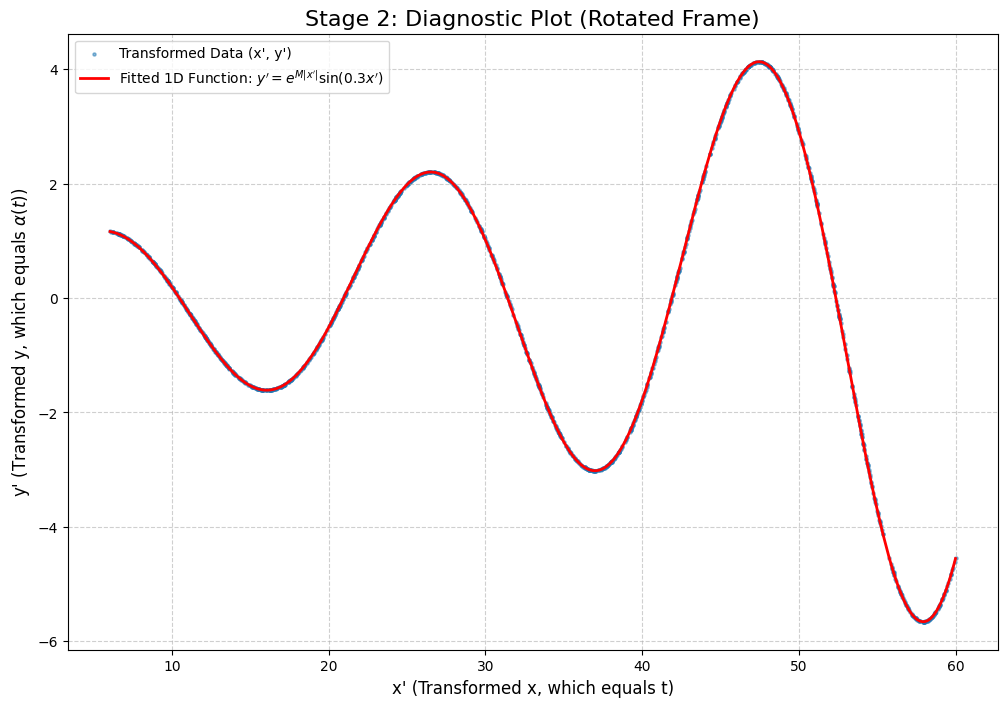

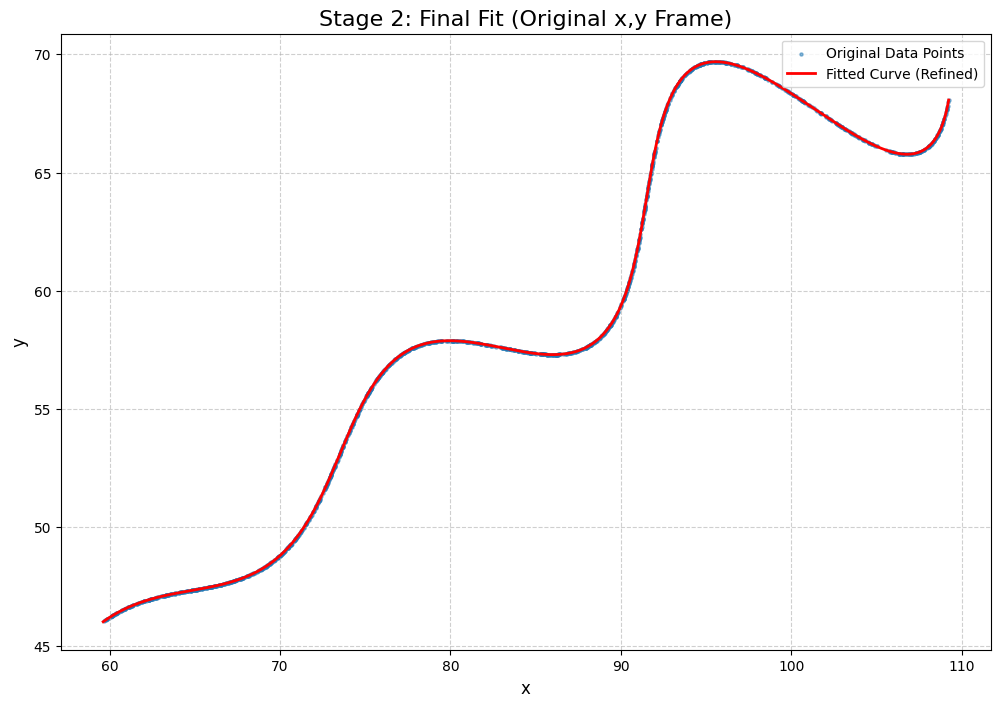

In [22]:
# --- 5. Stage 3: Final L1 Scoring (Grader's Metric) ---

# Helper function for forward prediction
def predict_curve(params, t):
    theta, M, X = params
    abs_t = np.abs(t)
    sin_0_3t = np.sin(0.3 * t)
    exp_term = np.exp(M * abs_t) * sin_0_3t
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    x_pred = t * cos_theta - exp_term * sin_theta + X
    y_pred = 42.0 + t * sin_theta + exp_term * cos_theta
    return x_pred, y_pred

def calculate_l1_score(params, x_data_global, y_data_global, t_target_global):
    """
    This is the "uniform-t L1 scoring (to mirror the grader)".
    This is Strategy B's loss function, used *only* for scoring.
    """
    x_pred, y_pred = predict_curve(params, t_target_global)
    l1_error = np.sum(np.abs(x_pred - x_data_global) + np.abs(y_pred - y_data_global))
    return l1_error

final_l1_score = calculate_l1_score(best_params, x_data, y_data, t_target)
print(f"\n=== Final L1 Score: {final_l1_score:.8f} ===")

theta_rad = best_params[0]
theta_deg = np.rad2deg(theta_rad)
M_val = best_params[1]
X_val = best_params[2]

print("\n=== Estimated Unknown Variables (Refined) ===")
print(f"  theta (radians): {theta_rad:.8f}")
print(f"  theta (degrees): {theta_deg:.8f}")
print(f"  M              : {M_val:.8f}")
print(f"  X              : {X_val:.8f}")

#7. Generate Diagnostic Plots

print("\nGenerating diagnostic plots...")

# -- Plot 1: Rotated Frame Diagnostic --
x_tilde = x_data - X_val
tilde_y = y_data - 42.0
cos_theta = np.cos(theta_rad)
sin_theta = np.sin(theta_rad)
x_prime = x_tilde * cos_theta + tilde_y * sin_theta
y_prime = - x_tilde * sin_theta + tilde_y * cos_theta

sort_indices = np.argsort(x_prime)
x_prime_sorted = x_prime[sort_indices]
y_prime_fit = np.exp(M_val * np.abs(x_prime_sorted)) * np.sin(0.3 * x_prime_sorted)

plt.figure(figsize=(12, 8))
plt.scatter(x_prime, y_prime, label='Transformed Data (x\', y\')', s=5, alpha=0.5)
plt.plot(x_prime_sorted, y_prime_fit, label='Fitted 1D Function: $y\' = e^{M|x\'|}\\sin(0.3x\')$', color='red', linewidth=2)
plt.title('Stage 2: Diagnostic Plot (Rotated Frame)', fontsize=16)
plt.xlabel('x\' (Transformed x, which equals t)', fontsize=12)
plt.ylabel('y\' (Transformed y, which equals $\\alpha(t)$)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
diagnostic_plot_filename = 'plot_rotated_frame.png'
plt.savefig(diagnostic_plot_filename)
print(f"Diagnostic plot saved as '{diagnostic_plot_filename}'")

# -- Plot 2: Original Frame Final Fit --
x_fit_final, y_fit_final = predict_curve(best_params, t_target)

plt.figure(figsize=(12, 8))
plt.scatter(x_data, y_data, label='Original Data Points', s=5, alpha=0.5)
plt.plot(x_fit_final, y_fit_final, label='Fitted Curve (Refined)', color='red', linewidth=2)
plt.title('Stage 2: Final Fit (Original x,y Frame)', fontsize=16)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
final_plot_filename = 'plot_original_frame.png'
plt.savefig(final_plot_filename)
print(f"Final fit plot saved as '{final_plot_filename}'")